# Building a LogS Regression Model

We will build a regression model for the Biogen solubility dataset: https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160

The purpose of writing this notebook is purely educational and the model should not be used in any real-life projects IMO. The model nonetheless is has poor predictive quality

### Step 1: Import all necessary libraries that might be necessary

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops, Draw, Descriptors, rdDepictor, PandasTools, rdMolDescriptors as rdmd;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mols2grid
import splito

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")
print(pd.__version__)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]
2.2.3


### Step 2: Check out what the dataframe looks like

In [52]:
df = pd.read_csv("../data/biogen_solubility.csv")
print(f"The dataset contains {df.shape[0]} endpoints on LogS")
df.head(3)

The dataset contains 2173 endpoints on LogS


,Internal ID,Vendor ID,SMILES,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-3.925969


<Axes: xlabel='logS', ylabel='Count'>

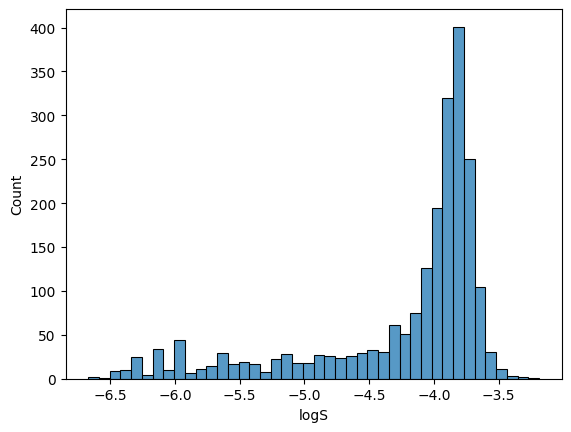

In [3]:
# Let's check the distribution of values:

sns.histplot(df.logS)

### Step 3: We now sanitize the dataset: check for faulty smiles and remove smiles with impurities

In [4]:
import sys
sys.path.insert(0, '/Users/ganeshshahane/Work/useful_cheminformatics/')

In [5]:
# remove smiles with invalid syntax:
from utils_pack import remove_faulty_smiles, clean_sanitize_dataframe

df = remove_faulty_smiles.remove(df, 'SMILES')

There are 0 invalid smiles in the dataset


Salts can have a huge influence on aqueous solubility, and hence it's not appropriate to include them in the training set. Let's remove salts and hydrates by removing any molecule containing more than one fragment:

In [6]:
# remove smiles with mutiple fragments and transition metals

new_df = clean_sanitize_dataframe.filter_smiles(df, 'SMILES')
print(f"{df.shape[0] - new_df.shape[0]} molecules have been removed by because of transition metals or salts")

There are 0 invalid smiles in the dataset
3 molecules have been removed by because of transition metals or salts


In [7]:
# Check which SMILES have been removed:

differences = pd.concat([df, new_df]).drop_duplicates(subset='SMILES', keep=False)

differences.SMILES.to_list()

['COc1ccc(-c2nc(CC(N)=O)sc2C)cc1.Cl',
 'CC(C)(C)C[C@@H]1COCc2nc(OCc3ccccn3)cc(=O)n21',
 'C=C(C)COc1cccc(C(=O)NCc2nncn2C2CCCCC2)c1']

As one can see, these entries are salts or contain multiple fragments

#### Finally, visualise the molecules:

In [8]:
# Calculate the mol object:
new_df['mol'] = new_df['SMILES'].apply(Chem.MolFromSmiles)

In [9]:
# Visualise some of the molecules:
#Draw.MolsToGridImage(new_df.mol[:10], molsPerRow=5)
mols2grid.display(new_df.mol[:8], size=(200,200), subset=["img", "SMILES"])

MolGridWidget()

In [10]:
new_df.head(5)

,Internal ID,Vendor ID,SMILES,logS,mol
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x2a6d35690>
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x2a6d35620>
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-3.925969,<rdkit.Chem.rdchem.Mol object at 0x2a6d35700>
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-4.535280,<rdkit.Chem.rdchem.Mol object at 0x2a6d35770>
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-4.709963,<rdkit.Chem.rdchem.Mol object at 0x2a6d357e0>


### Step 4: Generate features

In [11]:
# We use the molfeat package to generate descriptors

from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer

In [12]:
# Instantiate a Fingerprint calculator
calc = FPCalculator("ecfp")

# Instantiate a molecule transfomer from molfeat. This object takes a list of SMILES as input and returns descriptors.
trans = MoleculeTransformer(calc)

In [13]:
import datamol as dm

with dm.without_rdkit_log():
    
    new_df['fp'] = trans.transform(new_df.SMILES.values)

In [14]:
print(new_df.shape)
new_df.head(2)

(2170, 6)


,Internal ID,Vendor ID,SMILES,logS,mol,fp
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x2a6d35690>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x2a6d35620>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Step 5: Train-Test split

In [15]:
from splito import ScaffoldSplit

# Initialize a splitter
splitter = ScaffoldSplit(smiles=new_df["SMILES"].tolist(), n_jobs=-1, test_size=0.2, random_state=111)

# Generate indices for training set and test set
train_idx, test_idx = next(splitter.split(X=new_df.SMILES.values))

#assert train_idx.shape[0] > test_idx.shape[0]
new_df.loc[train_idx, "ScaffoldSplit"] = "train"
new_df.loc[test_idx, "ScaffoldSplit"] = "test"
new_df["scaffold"] = splitter.scaffolds

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

In [16]:
new_df.head(2)

,Internal ID,Vendor ID,SMILES,logS,mol,fp,ScaffoldSplit,scaffold
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x2a6d35690>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train,O=C(NC1CC1)c1cnc2ccc(Nc3cccn(-c4ccccn4)c3=O)nn12
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x2a6d35620>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train,O=C(Nc1ccc2n[nH]cc2c1)c1ccccn1


In [17]:
new_df.ScaffoldSplit.value_counts()

ScaffoldSplit
train    1738
test      432
Name: count, dtype: int64

In [18]:
# Split the dataframe based on ScaffoldSplit column
train_df = new_df[new_df.ScaffoldSplit == "train"]
test_df = new_df[new_df.ScaffoldSplit == "test"]

# Display the first few rows of each dataframe to verify the split
print("Training DataFrame:", train_df.shape)
#train_df.head(2)
print("Testing DataFrame:", test_df.shape)  

Training DataFrame: (1738, 8)
Testing DataFrame: (432, 8)


In [19]:
X_train = np.array(list(train_df.fp))
X_test = np.array(list(test_df.fp))
y_train = train_df.logS
y_test = test_df.logS

### Step 6: Fit the model

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initiate the regressor:
est = HistGradientBoostingRegressor()

# Fit the training data:
est.fit(X_train, y_train)

HistGradientBoostingRegressor()

### Step 7: Predict logS on molecules in the testing set:

In [21]:
X_test_predictions = est.predict(X_test)

X_test_predictions[:10]

array([-4.09454396, -4.39368613, -4.44899124, -4.27902401, -5.01772362,
       -4.6542807 , -4.45237652, -4.13016894, -4.19061591, -4.69366943])

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, X_test_predictions)
r2 = r2_score(y_test, X_test_predictions)

print(f"MSE: {mse}")
print(f"R2 score: {r2}")

MSE: 0.4191485413231671
R2 score: 0.22634789577039838


This is at best a poor positive correlation. The model isn't very good.

Let's visualise the regression:

<Axes: xlabel='logS'>

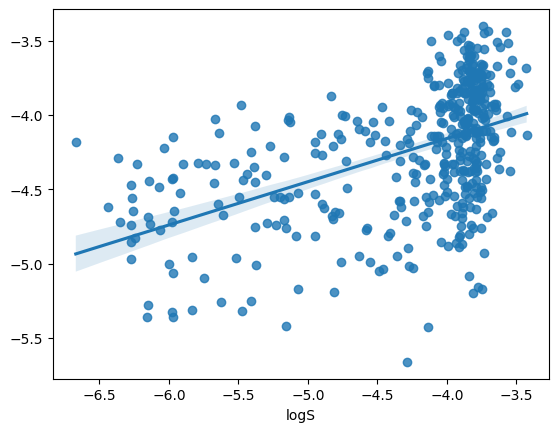

In [23]:
sns.regplot(x=y_test, y=X_test_predictions)

We can see the large blob of data with experimental logS (on X-axis) between -4.7 and -3.5 is predicted to be anywhere between -5.2 to -3.6.

I think we can do better.

### Step 8: Save & Reuse the model

In [24]:
import joblib

joblib.dump(est, '../saved_models/logS_regressor.model')

['../saved_models/logS_regressor.model']

#### Some time later...

In [25]:
# Load the saved model:

load_model = joblib.load('../saved_models/logS_regressor.model')

In order to predict the logS of a new molecule, you have to pass its features (in this case fingerprints) to the loaded model using predict(), and then convert those features in a series or dataframe:

In [26]:
load_model.predict(pd.DataFrame(trans.transform('CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O')))

array([-3.8641163])

In [27]:
# For multiple molecules:

mol_list = ['CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O', 'CCCC']

load_model.predict(pd.DataFrame(trans.transform(mol_list)))

array([-3.8641163, -3.7513256])

## However, can we improve the model's performance?

Let's try using 2D descriptors as features instead of fingerprints

In [28]:
from molfeat.calc import _CALCULATORS

print("The following descriptors are available in molfeat:")
_CALCULATORS.keys()

The following descriptors are available in molfeat:


dict_keys(['CATS', 'RDKitDescriptors2D', 'RDKitDescriptors3D', 'MordredDescriptors', 'FPCalculator', 'Pharmacophore2D', 'Pharmacophore3D', 'USRDescriptors', 'ElectroShapeDescriptors', 'ScaffoldKeyCalculator', 'AtomCalculator', 'AtomMaterialCalculator', 'DGLCanonicalAtomCalculator', 'DGLWeaveAtomCalculator', 'BondCalculator', 'EdgeMatCalculator', 'DGLCanonicalBondCalculator', 'DGLWeaveEdgeCalculator'])

In [29]:
# Instantiate a descriptor calculator
from molfeat.trans import MoleculeTransformer
from molfeat.calc import RDKitDescriptors2D

desc = RDKitDescriptors2D(replace_nan = True)

# Instantiate a molecule transfomer. This object takes a list of SMILES as input and returns descriptors.
featurizer = MoleculeTransformer(desc, dtype=np.float32)

with dm.without_rdkit_log():
    feats_train = featurizer(train_df.SMILES.values)
    feats_test = featurizer(test_df.SMILES.values)

In [30]:
# A total of 216 2D descriptors are computed:
pd.DataFrame(feats_train).head(3)

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,13.200851,13.200851,0.165008,-1.018011,0.424174,17.187500,434.434998,415.282990,434.161499,162.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
1,12.876019,12.876019,0.114613,-2.761275,0.572869,11.833333,418.444000,394.252014,418.181641,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11.185594,11.185594,0.434476,-1.299581,0.655493,11.222222,382.846985,363.695007,382.108429,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#chedk the shape of the features of test set:
pd.DataFrame(feats_test).head(3)

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,11.770706,11.770706,0.001815,0.001815,0.542398,14.062500,429.523987,402.308014,429.216461,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,14.727550,14.727550,0.073478,-4.248095,0.336426,11.451612,500.364014,488.268005,498.974274,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.091448,16.091448,0.010103,-0.927864,0.295475,15.357142,572.612000,542.372009,572.223511,216.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Next we normalise the features between 0 and 1

Because we are using phys-chem descriptors, we will normalise the features between 0 and 1

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize
scaler = MinMaxScaler()

# Fit and transform the data
X_train_normalized = scaler.fit_transform(feats_train)
X_test_normalized = scaler.fit_transform(feats_test)

# Print the first few rows of the normalized data
print("Normalized Data (MinMaxScaler):")
pd.DataFrame(X_train_normalized).head(3)

Normalized Data (MinMaxScaler):


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.815177,0.815177,0.159889,0.701832,0.333463,0.216066,0.552378,0.571090,0.552412,0.534653,...,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.2,0.0,0.0
1,0.786813,0.786813,0.111051,0.448269,0.522669,0.073684,0.521307,0.527126,0.521340,0.524752,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.0
2,0.639207,0.639207,0.421030,0.660877,0.627802,0.057433,0.452142,0.463248,0.451197,0.415842,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [33]:
pd.DataFrame(X_test_normalized).head(3)

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.679226,0.679226,0.001456,0.817965,0.449192,0.138577,0.492565,0.492043,0.492551,0.521277,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.25
1,0.898743,0.898743,0.066249,0.117467,0.168549,0.060348,0.644721,0.687718,0.642477,0.500000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00
2,1.000000,1.000000,0.008949,0.664729,0.112751,0.177368,0.799900,0.810877,0.799906,0.797872,...,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.25,0.0,0.00


### Test-Train Splitting and model building

Thus we have X_train_normalized, X_test_normalized, y_train and y_test

But let's rename y sets:

In [34]:
y1_train = train_df.logS
y1_test = test_df.logS

In [35]:
# Initiate the regressor:
gbm = HistGradientBoostingRegressor()

# Fit the training data:
gbm.fit(X_train_normalized, y1_train)

# Predict logS of the testing set:
y1_pred = gbm.predict(X_test_normalized)

# Show top 10 predictions
y1_pred[:10]

array([-5.21215574, -4.66235256, -4.61347665, -5.12901433, -4.75200078,
       -4.7951471 , -4.88780649, -4.32845108, -4.61249803, -4.88240883])

In [36]:
# Evaluate the model's predictions:

mse_gbm = mean_squared_error(y1_test, y1_pred)
r2_gbm = r2_score(y1_test, y1_pred)

print(f"MSE: {mse_gbm}")
print(f"R2 score: {r2_gbm}")

MSE: 0.4931908230644462
R2 score: 0.08968282020966556


One can see that while the MSE has improved slightly, the R2 score is much worse and the performance has not improved much at all.

Now let's visualise the correlation:

<Axes: xlabel='logS'>

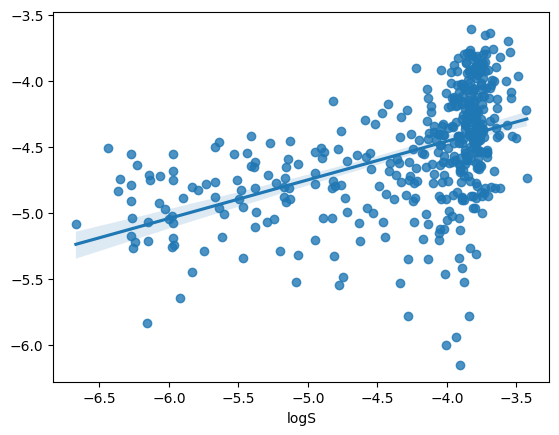

In [37]:
sns.regplot(x=y1_test, y=y1_pred)

The performance and overall correlation is just the same or worse.

In [38]:
# Let's save the model:

joblib.dump(gbm, '../saved_models/logS_regressor_V2.model')

['../saved_models/logS_regressor_V2.model']

In [39]:
# Sometime later:

model_V2 = joblib.load('../saved_models/logS_regressor_V2.model')

When testing the model on new molecules, the model automatically normalizes its generated features:

In [40]:
# Predicting value of one molecule:

model_V2.predict(pd.DataFrame(featurizer('CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O')))

[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer


array([-4.44692561])

In [41]:
# For multiple molecules:

mol_list = ['CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O', 'CCCC']

model_V2.predict(pd.DataFrame(featurizer(mol_list)));

[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer


In [42]:
# Predicting values for molecules in a dataframe:

sample_df = pd.DataFrame({           # define a sample dataframe
    'ID':[1, 2],
    'smiles': ['c1ccccc1N', 'CCON']
    })

sample_df

,ID,smiles
0,1,c1ccccc1N
1,2,CCON


In [43]:
# Define a function to return the predicted logS:

def predict_logS(smiles):
    
    return model_V2.predict(pd.DataFrame(featurizer(smiles))).item()

In [44]:
sample_df['predicted_logS'] = sample_df['smiles'].apply(predict_logS)

[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer
[08:36:55] Initializing MetalDisconnector
[08:36:55] Running MetalDisconnector
[08:36:55] Initializing Normalizer
[08:36:55] Running Normalizer


In [45]:
sample_df

,ID,smiles,predicted_logS
0,1,c1ccccc1N,-4.997779
1,2,CCON,-4.272064
